In [1]:
using PauliPropagation
using Plots
using Printf
using LinearAlgebra
using LaTeXStrings
using ProgressMeter

[ Info: Precompiling PauliPropagation [293282d5-3c99-4fb6-92d0-fd3280a19750] (cache misses: include_dependency fsize change (4), wrong source (8))
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing PauliPropagation [293282d5-3c99-4fb6-92d0-fd3280a19750].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [2]:
function jordan_wigner_tfim(n_sites::Int, J::Float64=1.0, h::Float64=1.0)
    """
    Construct the Bogoliubov-de Gennes matrix for the transverse-field Ising model:
    H = -J Σ σ^z_i σ^z_{i+1} - h Σ σ^x_i

    Args:
        n_sites (Int): Number of sites
        J (Float64): Coupling strength for σ^z σ^z interaction
        h (Float64): Transverse field strength

    Returns:
        Matrix{Float64}: 2n_sites × 2n_sites BdG matrix
    """
    A = zeros(Float64, n_sites, n_sites)
    B = zeros(Float64, n_sites, n_sites)

    for i in 1:(n_sites-1)
        A[i, i] = h
        A[i+1, i+1] = h
    end

    for i in 1:(n_sites-1)
        A[i, i+1] = -J/2
        A[i+1, i] = -J/2
    end

    for i in 1:(n_sites-1)
        B[i, i+1] = -J/2
        B[i+1, i] = J/2
    end

    M = [A  B;
        -B -A]

    return M
end

function zz_correlation(M::Matrix{Float64}, beta::Float64, i::Int, j::Int)
    N = size(M, 1) ÷ 2

    eigvals, eigvecs = eigen(Hermitian(M))

    # Extract u and v components
    Uk = eigvecs[1:N, :]
    Vk = eigvecs[N+1:end, :]

    # Thermal occupations
    f = 1.0 ./ (exp.(2 * beta .* eigvals) .+ 1.0)
    f_diag = Diagonal(f)

    G = Uk * f_diag * Uk'
    F = Uk * f_diag * Vk'

    zz = 4 * (G[i,i] - 0.5) * (G[j,j] - 0.5) - 4 * G[i,j] * G[j,i] + 4 * abs2(F[i,j])

    return zz
end

zz_correlation (generic function with 1 method)

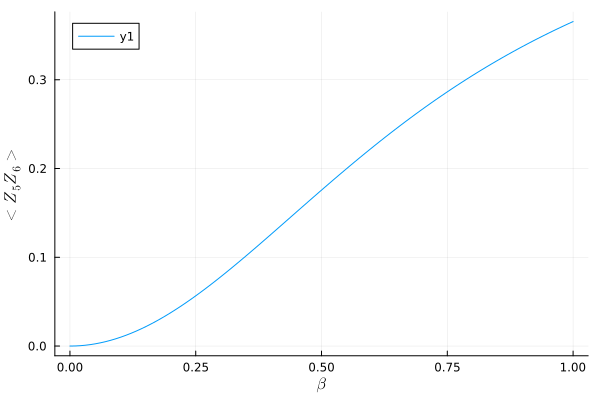

In [3]:
M = jordan_wigner_tfim(6, 1.0, 1.0)
betaExact = range(0.0, 1.0, length=100)
zz = zeros(length(betaExact))
for i in 1:length(betaExact)
    zz[i] = zz_correlation(M, betaExact[i], 3, 4)
end

plot(betaExact, zz, xlabel=L"\beta", ylabel=L"<Z_5Z_6>")

In [4]:
function thermalStateComparison(H, circuit, beta, theta, nq; max_weight=nq, min_abs_coeff=1e-10)
    analyticResult = imaginaryTimeEvolution(H, -beta)
    pstr = PauliString(nq, :I, 1)
    totalAngle = 0
    psum = PauliSum(pstr)
    while totalAngle < beta
        # psum = PauliSum(pstr)
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        totalAngle += imag(theta)
    end
    pstr = topaulistrings(psum)
    distance = computeTwoNorm(pstr, analyticResult, nq)
    return distance
end

function thermalStateExpectation(circuit, nl, nq, operator; max_weight=nq, min_abs_coeff=0)
    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)

    expectations = Float64[]

    @showprogress for layers in 1:nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        layers += 1
        pstr = topaulistrings(psum)
        expectation = 0
        for i in 1:size(pstr)[1]
            string = inttostring(pstr[i].term, nq)
            if string == operator
                expectation = pstr[i].coeff
            end
        end
        expectations = push!(expectations, expectation)
    end
    return expectations
end

function thermalStateExpectation2(circuit, nl, nq, pstr; max_weight=nq, min_abs_coeff=0)

    psum = PauliSum(PauliString(nq, :I, 1))
    layers = 0

    while layers < nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        layers += 1
    end
    psum2 = PauliSum(pstr)

    return overlapwithpaulisum(psum,psum2)*2^nq
end

function thermalStateExpectationComparison(H, circuit, beta, theta, nq, operator; max_weight=nq, min_abs_coeff=0, errorType="relative")
    analyticDensity = imaginaryTimeEvolution(H, -beta)
    pstr = PauliString(nq, :I, 1)
    totalAngle = 0
    psum = PauliSum(pstr)

    while totalAngle < beta
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        totalAngle += imag(theta)
    end

    pstr = topaulistrings(psum)
    expectationAnalytic = expectationValue(analyticDensity, operator)
    expectationPP = 0
    for i in 1:size(pstr)[1]
        string = inttostring(pstr[i].term, nq)
        if string == operator
            expectationPP = pstr[i].coeff
        end
    end
    expectationPP = 2^nq*expectationPP 
    if errorType == "absolute"
        error = abs(expectationPP - expectationAnalytic)
    elseif errorType == "relative"
        error = abs(expectationPP - expectationAnalytic)/abs(expectationAnalytic)
    end
    return error
end

function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function YMatrix(n::Int, i::Int)
    Ymat = [0 -im; im 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Ymat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Ymat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function imaginaryTimeEvolution(h::Matrix, beta::Float64)
    operator = exp(-beta*h)
    return operator/tr(exp(-beta*h))
end

function imaginaryTimeEvolutionState(h::Matrix, beta::Float64, state::Vector)
    operator = exp(-beta*h)*state
    return operator/LinearAlgebra.norm(operator)
end

function comparison(P::Matrix, Q::Matrix, beta::Float64)
    num = exp(-beta/2*P)*Q*exp(-beta/2*P)
    C = commutator2(P, Q)
    if (LinearAlgebra.norm(C) < 1e-3)
        analytic = cosh(beta)*Q-sinh(beta)*P*Q
    else
        analytic = Q
    end 
    println("Numerical: ", num)
    println("Analytic: ", analytic)
    println(LinearAlgebra.norm(num-analytic))
end
function interpretPauli(p::String)
    I = [1 0; 0 1]
    X = [0 1; 1 0]
    Y = [0 -1im; 1im 0]
    Z = [1 0; 0 -1]

    if p[1] == 'I'
        mat = I
    elseif p[1] == 'X'
        mat = X
    elseif p[1] == 'Y'
        mat = Y
    elseif p[1] == 'Z'
        mat = Z
    end

    for i in 2:length(p)
        if p[i] == 'I'
            mat = kron(mat, I)
        elseif p[i] == 'X'
            mat = kron(mat, X)
        elseif p[i] == 'Y'
            mat = kron(mat, Y)
        elseif p[i] == 'Z'
            mat = kron(mat, Z)
        end
    end
    return mat
end

function generatePauliBasis(nqubits::Int)
    basis = Vector{String}(undef, 4^nqubits)
    for i in 1:4^nqubits
        basis[i] = join(rand(['I', 'X', 'Y', 'Z'], nqubits))
    end
    return basis
end

function computeTwoNorm(pstr::Vector, rho::Matrix, nq::Int)
    A = 0
    B = LinearAlgebra.norm(rho)^2
    mix = 0
    for i in 1:size(pstr)[1]
        A += abs(pstr[i].coeff)^2
        string = (inttostring(pstr[i].term,nq))
        mix += pstr[i].coeff*tr(rho*interpretPauli(string))
    end
    A *= 2^nq
    return A+B-2*mix
end

function expectationValue(rho::Matrix, pauli::String)
    mat = interpretPauli(pauli)
    return tr(rho*mat)
end

expectationValue (generic function with 1 method)

In [19]:
theta = 0.01im
θ = theta
nq = 30

nl = 1

pstr = PauliString(nq, :I, 1)

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), -θ)
rxmat = tomatrix(PauliRotation(:X, 1), -θ)
rzzmat = tomatrix(PauliRotation([:X, :X], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
for i in 1:nl
    #append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
    append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
    append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);
end

psum = propagate(circuit, pstr, normalization=true, min_abs_coeff=2^(-20))


PauliSum(nqubits: 30, 31001 Pauli terms:
 -9.997e-7 * IIIIIIIXXIZIIIIIIIII...
 -9.997e-7 * IIIIXXIIIIIIIZIIXXII...
 -9.997e-7 * IIIIXXIIIIIXXIIIIIII...
 -9.997e-7 * IIIIIXXIIIIIXXIIIIII...
 -9.996e-7 * IIIIIIIIIIXXIIIIIIXX...
 -9.997e-7 * IIIIIIIIIIIIIIXXIIII...
 -9.997e-7 * IIIIIIIIIIIIIXXIIIII...
 -9.996e-7 * IIIIIXXIIIIIIIIIIIII...
 -9.999e-7 * IIIIIIIIIIIZIIIIIIII...
 -9.997e-7 * ZIIIIIIIIIIIXXIIIIII...
 -9.997e-7 * IIIIIIIIXXXXIIIIIIII...
 -9.997e-7 * IIIIZIIIIIIIXXIIIIII...
 -9.999e-7 * IIIIIIZIIIIIIIIIIZII...
 -9.999e-7 * IIIIIZIIIIIIIZIIIIZI...
 -9.997e-7 * IIIIIXXIIIIIIIIIIZIX...
 -9.998e-7 * IIIIIIIIIIIXXIIIIIII...
 -9.999e-7 * IIIIIZIIIIIIIIIIIIII...
 -9.999e-7 * IIIIIIIIIIIIIIIIZZII...
 -9.999e-7 * IIIIIIIIIIIZIIIIIIII...
 -9.996e-7 * IIIIIXXIIIIIXXIIIIII...
  ⋮)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


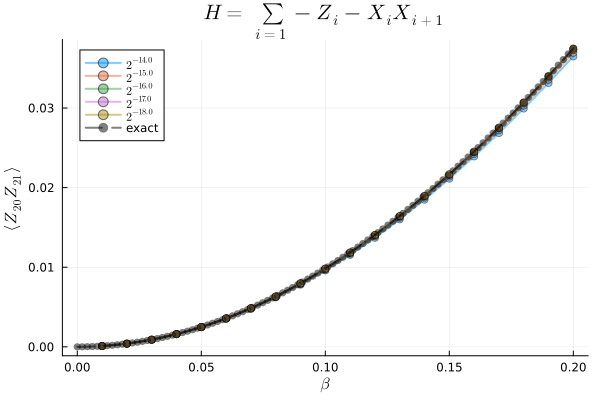

In [6]:
obs_i = 5
obs_j = 6
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])
observable = inttostring(observable.term, nq)

nl = 20
trunc_coeffs = 2.0 .^ (-14:-1:-18)

time = range(0.01, 0.01*nl, nl)

plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")


for j in trunc_coeffs
    expectation = thermalStateExpectation(circuit, nl, nq, observable; min_abs_coeff=j, max_weight = 9)
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
end

M = jordan_wigner_tfim(nq, 1.0, 1.0)
betaExact = range(0.0, time[end], length=100)
zz = zeros(length(betaExact))
for i in 1:length(betaExact)
    zz[i] = zz_correlation(M, betaExact[i], obs_i, obs_j)
end

plot!(betaExact, zz, label = "exact", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5, color = :black, linestyle = :dash)
display(plot!())


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


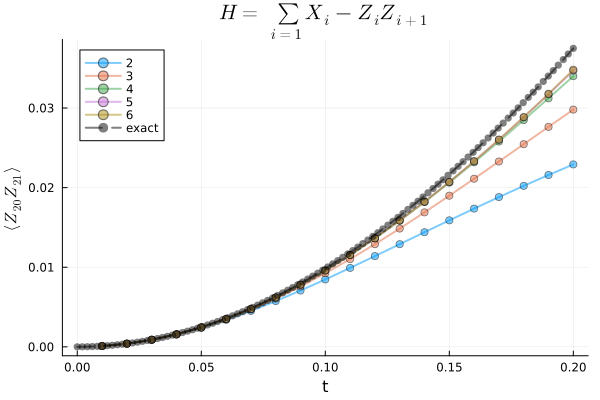

In [95]:
observable = PauliString(nq, [:Z,:Z], [20,21])
observable = inttostring(observable.term, nq)

nl = 20
weights = 2:1:6

time = range(0.01, 0.01*nl, nl)

plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel="t", title = L"$H = \sum_{i=1} X_i - Z_iZ_{i+1}$")


for j in weights
    expectation = thermalStateExpectation(circuit, nl, nq, observable; min_abs_coeff=2^(-16), max_weight = j)
    plot!(time, expectation, label = j, legend=:bottomleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
end

M = jordan_wigner_tfim(nq, 1.0, 1.0)
betaExact = range(0.0, time[end], length=100)
zz = zeros(length(betaExact))
for i in 1:length(betaExact)
    zz[i] = zz_correlation(M, betaExact[i], obs_i, obs_j)
end

plot!(betaExact, zz, label = "exact", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5, color = :black, linestyle = :dash)

display(plot!())


In [20]:
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])
observable = inttostring(observable.term, nq)

nl = 20
trunc_coeffs = 2.0 .^ (-14:-1:-18)

time = range(0.01, 0.01*nl, nl)

plot(ylabel=L"Absolute error of $\langle Z_{20}Z_{21} \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

M = jordan_wigner_tfim(nq, 1.0, 1.0)
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

for j in trunc_coeffs
    expectation = thermalStateExpectation(circuit, nl, nq, observable; min_abs_coeff=j, max_weight = 9)
    error = abs.(expectation - zz)
    plot!(time, error, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
end
plot!(yscale=:log10)

display(plot!())

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09
Progress:  25%|███████████                              |  ETA: 0:00:05

In [ ]:
observable = PauliString(nq, [:Z,:Z], [20,21])
observable = inttostring(observable.term, nq)

nl = 20
weights = 2:1:6

time = range(0.01, 0.01*nl, nl)

plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel="t", title = L"$H = \sum_{i=1} X_i - Z_iZ_{i+1}$")


for j in weights
    expectation = thermalStateExpectation(circuit, nl, nq, observable; min_abs_coeff=2^(-16), max_weight = j)
    plot!(time, expectation, label = j, legend=:bottomleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
end

M = jordan_wigner_tfim(nq, 1.0, 1.0)
betaExact = range(0.0, time[end], length=100)
zz = zeros(length(betaExact))
for i in 1:length(betaExact)
    zz[i] = zz_correlation(M, betaExact[i], obs_i, obs_j)
end

plot!(betaExact, zz, label = "exact", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5, color = :black, linestyle = :dash)

display(plot!())
